In [1]:
# I will start by importing some libraries I will need, we will be using PyTorch as our weapon of choice to build these networks

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

import numpy as np
import json



In [2]:
# I will now load in the inception_v3 model, and using it for all these examples

model = models.inception_v3(pretrained=True)

device = torch.device("cuda") # I am blessed with a CUDA gpu

model.to(device)
model.eval() #stops us acidentally altering the model, "finalising" it

print("Loaded inception model")

Loaded inception model


Here is the code I will be using to load in my example images. I have chosen 9 images of cats. You can also see that Inception-V3 classifies them all correctly as such.

In [4]:
loader = transforms.Compose([transforms.Resize([299, 299]), transforms.ToTensor()])

def load_dataset():
    data_path = 'cats'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=loader
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=9,
        num_workers=0,
        shuffle=True
    )
    return train_loader

for data, target in load_dataset():
    data = data.cuda()
    output = model(data)

predictions = torch.max(output.data, 1)[1].cpu().numpy()

with open("imagenet_class_index.json", "r") as classes:
    class_idx = json.load(classes)
    for p in predictions:
        print(class_idx[str(p)][1])

tiger_cat
tabby
tabby
Egyptian_cat
Egyptian_cat


## Can we take this further?

One way of taking this further would be to be able to target what we want the adversary to be classified as. We can achieve this by doing similar to before, but rather than maximising error, we <b>minimise error against a false target class</b>. 

In this example I will demonstrate altering images of candles so that Inception believes them to be Mittens. (based off of work from [Athalye, A., Engstrom, L., Ilyas, A. and Kwok, K., 2017. Synthesizing robust adversarial examples. arXiv preprint arXiv:1707.07397.](https://arxiv.org/pdf/1707.07397.pdf))

Feel free to change the "target_class" value below to an amusing class of your choice. This will work with any target class (with varying degrees of success)

In [5]:
def create_targeted_adversary(image, epsilon, gradient):
    
    # Similar to before, but now we are minimizing error!
    perturbed_image = image - epsilon * gradient
    
    # this just makes sure that the image values are still within its boundaries
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
    return perturbed_image

In [6]:
epsilon = 0.1
target_class = 924 # Guacamole
batch_size = 5


t = [target_class] * batch_size

output = None

example_found = [False] * batch_size
adversarial_examples = [None] * batch_size
prediction_names = [None] * batch_size

num_found = 0


with open("imagenet_class_index.json", "r") as classes:
    class_indexes = json.load(classes)

# Loop over all examples in test set
count = 0
for data, target in load_dataset():
    
    target = torch.LongTensor(t)
    
    while num_found < len(t):
        count += 1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero  gradients
        model.zero_grad()

        # Calculate gradient
        loss.backward()
        
        data_grad = data.grad.data
 
        # Attempt to create a targeted adversary
        perturbed_data = create_targeted_adversary(data, epsilon, data.grad)
        
        if not output is None:
            predictions = torch.max(output.data, 1)[1].cpu().numpy()
            for ii in range(len(predictions)):
                if example_found[ii] != True and predictions[ii] == target_class:
                    adversarial_examples[ii] = data[ii].cpu().detach().permute(1, 2, 0)
                    example_found[ii] = True
                    prediction_names[ii] = class_indexes[str(predictions[ii])][1]

                    num_found = 0
                    for found in example_found:
                        if found:
                            num_found += 1
                    
                    print(num_found, "adversarial examples have been found after", count, "iterations")
        
        data = perturbed_data.clone().detach()

        # Re-classify the perturbed image
        output = model(perturbed_data)

1 adversarial examples have been found after 25 iterations
2 adversarial examples have been found after 50 iterations
3 adversarial examples have been found after 54 iterations
4 adversarial examples have been found after 72 iterations
5 adversarial examples have been found after 75 iterations


In [8]:
def inception_thinks(idx):
    plt.imshow(adversarial_examples[idx])
    plt.axis('off')
    print("Inception-V3 thinks that this is an image of a", prediction_names[idx])

Inception-V3 thinks that this is an image of a guacamole


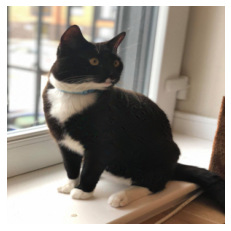

In [9]:
inception_thinks(0)

Inception-V3 thinks that this is an image of a guacamole


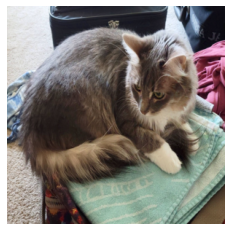

In [10]:
inception_thinks(1)

Inception-V3 thinks that this is an image of a guacamole


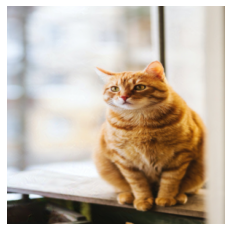

In [11]:
inception_thinks(2)

Inception-V3 thinks that this is an image of a guacamole


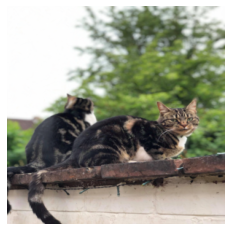

In [12]:
inception_thinks(3)

Inception-V3 thinks that this is an image of a guacamole


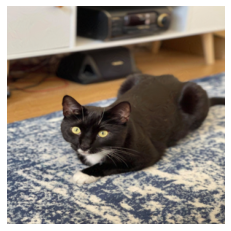

In [13]:
inception_thinks(4)

As you can see, with your own eyes... every image has been classified as a mitten, but still looks an afwul lot like a candle, right?

This concept is actually taken further in the "Robust Adversarial Examples" paper, where the team of researchers actually manufature a "Real World Adversarial Example" and create a model of a [turtle that inception believes is a rifle](https://youtu.be/XaQu7kkQBPc)

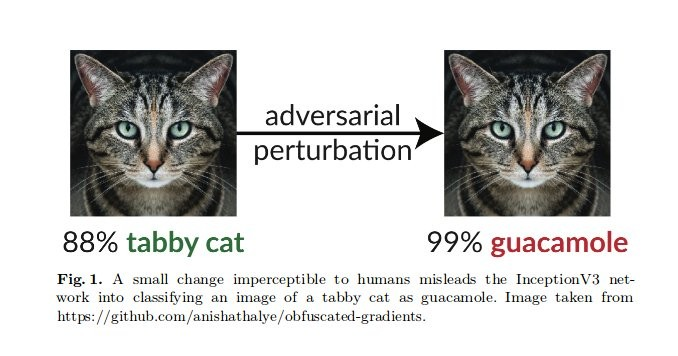 (the earlier presented cat-guacamole image was based on the same research)

## Why is this all so important? What does it mean for the field of AI and Machine Learning?

As mentioned earlier, I would not blame someone for thinking that image classification models are "better" than humans at classification. And when looking at error comparisons, that may hold true. But these examples show that there are some gaping holes in Inception's ability to "understand" an image, despite it's error being superior to human levels.

There has been some great research done since this issue was discovered, such as [You, Z., Ye, J., Li, K., Xu, Z. and Wang, P., 2019, September. Adversarial noise layer: Regularize neural network by adding noise. In 2019 IEEE International Conference on Image Processing (ICIP) (pp. 909-913). IEEE.](https://arxiv.org/pdf/1805.08000.pdf) where researchers realised that adding noise to the model could increase the robustness of a model and help defend against adversarial attacks.

After coming so far with error rates, ensuring that models we create in the future do not make these sorts of errors in the future may well get us closer to creating classifier that truly outperform human understanding.